# 线性回归

小结:
1. torch 中 zero_() 等_后缀的方法表示原地修改，无后缀表示返回一个新的量。  
2. 优化器实现可以参考下，总结来说是将模型参数初始化保存，然后根据每个参数的梯度，对其进行梯度下降。  
3. param -= self.lr * param.grad 原地修改param值  
   param = param - self.lr * param.grad 原始内存数据没有修改，新开辟内存赋值param，会多占用内存。  
4.   
  
```python 
     def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        # self()调用了 Module 重写的 forward 直接用于计算， *将列表分解，提取列表中的X
        self.plot('loss', l, train=False)
    ```
5. 
由于y在no_grad外部计算，因此计算y依赖的所有参数的梯度已经计算  
```python
x = torch.tensor([1.], requires_grad=True)
y = x * 2
with torch.no_grad(): 
       y.backward()
```
y在no_grad中计算，因此没有保留梯度，使用backward报错。  
```python
x = torch.tensor([1.], requires_grad=True)
with torch.no_grad(): 
       y = x * 2
       y.backward()
```


6.  
    nn.Module 在其中添加模型后，会直接将模型的参数与当前类绑定，即 self.parameters() 会输出该类中定义所有模型的参数  

7. 
使用 _ 后缀的方法原地修改模型参数  
```python
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)  
        self.net.bias.data.fill_(0)
``` 

   

损失函数深入理解

1. 使用MSE作为损失函数，会使得模型倾向减少**异常值**的损失，因此需要排除异常值

2. 使用MSE做为线性模型损失函数的统计学联系，假设数据采样存在高斯噪声，则：

$$y = \mathbf{w}^\top \mathbf{x} + b + \epsilon \textrm{ where } \epsilon \sim \mathcal{N}(0, \sigma^2).$$

针对误差的最大似然估计得出

$$-\log P(\mathbf y \mid \mathbf X) = \sum_{i=1}^n \frac{1}{2} \log(2 \pi \sigma^2) + \frac{1}{2 \sigma^2} \left(y^{(i)} - \mathbf{w}^\top \mathbf{x}^{(i)} - b\right)^2.$$

当$\sigma$为常数时，最大似然与使用MSE优化线性模型结果相同。

In [22]:
import base_module
import torch
import numpy as np
from torch import nn

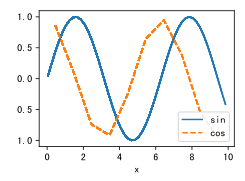

In [3]:
board = base_module.ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=10)

## 1.生成基础数据

In [5]:
class SyntheticRegressionData(base_module.DataModule):
    """Synthetic data for linear regression."""
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) * noise
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise
        
    def get_dataloader(self, train):
        if train:
            indices = list(range(0, self.num_train))
            # The examples are read in random order
            random.shuffle(indices)
        else:
            indices = list(range(self.num_train, self.num_train+self.num_val))
        for i in range(0, len(indices), self.batch_size):
            batch_indices = torch.tensor(indices[i: i+self.batch_size])
            yield self.X[batch_indices], self.y[batch_indices]

使用all_to_class装饰器 可以在实例化后添加方法

In [6]:
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)

In [7]:
@base_module.add_to_class(SyntheticRegressionData) 
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size,
                                       shuffle=train)

In [8]:
@base_module.add_to_class(SyntheticRegressionData) 
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

# 2. 线性回归模型

## 2.1 定义模型

In [9]:
class LinearRegressionScratch(base_module.Module):
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
#         self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.w = torch.zeros((num_inputs,1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

In [10]:
@base_module.add_to_class(LinearRegressionScratch)
def forward(self, X):
    return torch.matmul(X, self.w) + self.b

## 2.2 定义loss

In [11]:
@base_module.add_to_class(LinearRegressionScratch)
def loss(self, y_hat, y):
#     l = (y_hat - y) ** 2 / 2
    l = (y_hat - torch.reshape(y, y_hat.shape)).abs().sum()
#     return l.mean()
    return l

## 2.3 定义优化器

In [12]:
class SGD(base_module.HyperParameters): 
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad  # 这个是原地操作

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [13]:
@base_module.add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

In [16]:
model = LinearRegressionScratch(2, lr=0.03)
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = base_module.Trainer(max_epochs=10)


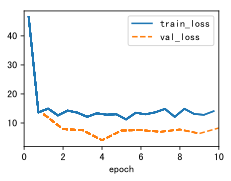

In [17]:
trainer.fit(model, data)

## 使用 torch 高级 api

In [52]:
class LinearRegression(base_module.Module):  #@save
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)
    
    def forward(self, X):
        return self.net(X)
    
    def loss(self, y_hat, y):
        fn = nn.MSELoss()
        return fn(y_hat, y)
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), self.lr)

In [55]:
model = LinearRegression(lr=0.03)
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = base_module.Trainer(max_epochs=3)

Uninitialized parameter
Parameter containing:
tensor([-3.6175e-29], requires_grad=True)
Parameter containing:
tensor([[ 0.3741,  0.3345,  0.3621],
        [ 0.5150, -0.2547,  0.5269]], requires_grad=True)
Parameter containing:
tensor([ 0.5000, -0.1906], requires_grad=True)


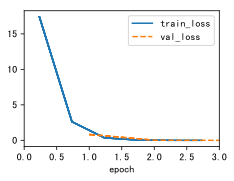

In [38]:
trainer.fit(model, data)

## 正则化

1. 在线性回归中，L2 正则化与权重衰减效果相同；
2. pytorch中可以直接设定权重衰减系数，不同参数设定不同衰减策略  
```python
torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)
```

## QA

1. 为何不使用二阶导数？  
A： 1.二阶导数为矩形，不好求；2.其次达到导数为零的点没有意义，因为统计假设模型只是假设，并不是完全符合事实，因此不需要求得零点。  
2. 计算结果出现NAN的情况？  
A：